In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

# Brain Tumor MRI Classification — Akbank DL Bootcamp (CNN Model)

Bu proje, **Akbank Derin Öğrenme Bootcamp** kapsamında gerçekleştirilmiştir.  
Amaç, **MRI beyin görüntülerinden tümör tiplerini** (glioma, meningioma, no tumor, pituitary) derin öğrenme tabanlı bir model ile sınıflandırmaktır.  

Modelde **EfficientNetB0** transfer learning yöntemi kullanılmış, eğitim sürecinde elde edilen çıktılar görselleştirilmiştir:

- 📊 Eğitim/Doğrulama doğruluk ve kayıp grafikleri  
- 📈 Confusion Matrix  
- 📑 Classification Report  
- 🔥 Grad-CAM görselleştirmeleri  
- ⚙️ Hiperparametre denemeleri  

Sonuç olarak model, test setinde **%93 doğruluk (accuracy)** seviyesine ulaşmıştır.  

## Dataset
  
Proje çıktıları ve görselleştirmeler ise bu repoda yer almaktadır.  

- Toplam 5712 MRI görüntüsü  
- 4 sınıf: **Glioma, Meningioma, No Tumor, Pituitary**  
- Train / Validation / Test ayrımı otomatik yapılmıştır.


In [2]:
import os, itertools, random, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
import random
np.random.seed(42); random.seed(42); tf.random.set_seed(42)
from tensorflow.keras import layers, models
from tensorflow.keras.applications import efficientnet
from sklearn.metrics import confusion_matrix, classification_report

print("TF version:", tf.__version__)


2025-09-26 15:17:34.718615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758899855.084556      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758899855.183797      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF version: 2.18.0


In [3]:
SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# Kaggle dataset kök yolu
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"

# Eğer içinde tek bir klasör varsa (ör. "Brain Tumor MRI Dataset"), oraya içeri dal
subdirs = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
if len(subdirs) == 1:
    DATA_DIR = os.path.join(DATA_DIR, subdirs[0])

# Train/Test klasörlerini kontrol et (Training/Testing, train/test, vs.)
train_candidates = ["Training", "training", "Train", "train"]
test_candidates  = ["Testing", "testing", "Test", "test"]

train_dir, test_dir = None, None
for c in train_candidates:
    p = os.path.join(DATA_DIR, c)
    if os.path.isdir(p):
        train_dir = p
        break

for c in test_candidates:
    p = os.path.join(DATA_DIR, c)
    if os.path.isdir(p):
        test_dir = p
        break

HAS_SEPARATE_TEST = test_dir is not None
(train_dir, test_dir, HAS_SEPARATE_TEST)



('/kaggle/input/brain-tumor-mri-dataset/Training',
 '/kaggle/input/brain-tumor-mri-dataset/Testing',
 True)

In [4]:
if train_dir is None:
    # Tek klasör ise, %20 validation split
    root_dir = DATA_DIR
    train_ds = tf.keras.utils.image_dataset_from_directory(
        root_dir, label_mode='categorical', image_size=IMG_SIZE,
        batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
        validation_split=0.2, subset='training'
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        root_dir, label_mode='categorical', image_size=IMG_SIZE,
        batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
        validation_split=0.2, subset='validation'
    )
    test_ds = val_ds
else:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir, label_mode='categorical', image_size=IMG_SIZE,
        batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
        validation_split=0.2, subset='training'
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir, label_mode='categorical', image_size=IMG_SIZE,
        batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
        validation_split=0.2, subset='validation'
    )
    if HAS_SEPARATE_TEST:
        test_ds = tf.keras.utils.image_dataset_from_directory(
            test_dir, label_mode='categorical', image_size=IMG_SIZE,
            batch_size=BATCH_SIZE, shuffle=False
        )
    else:
        test_ds = val_ds

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.


I0000 00:00:1758899874.267412      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758899874.268157      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


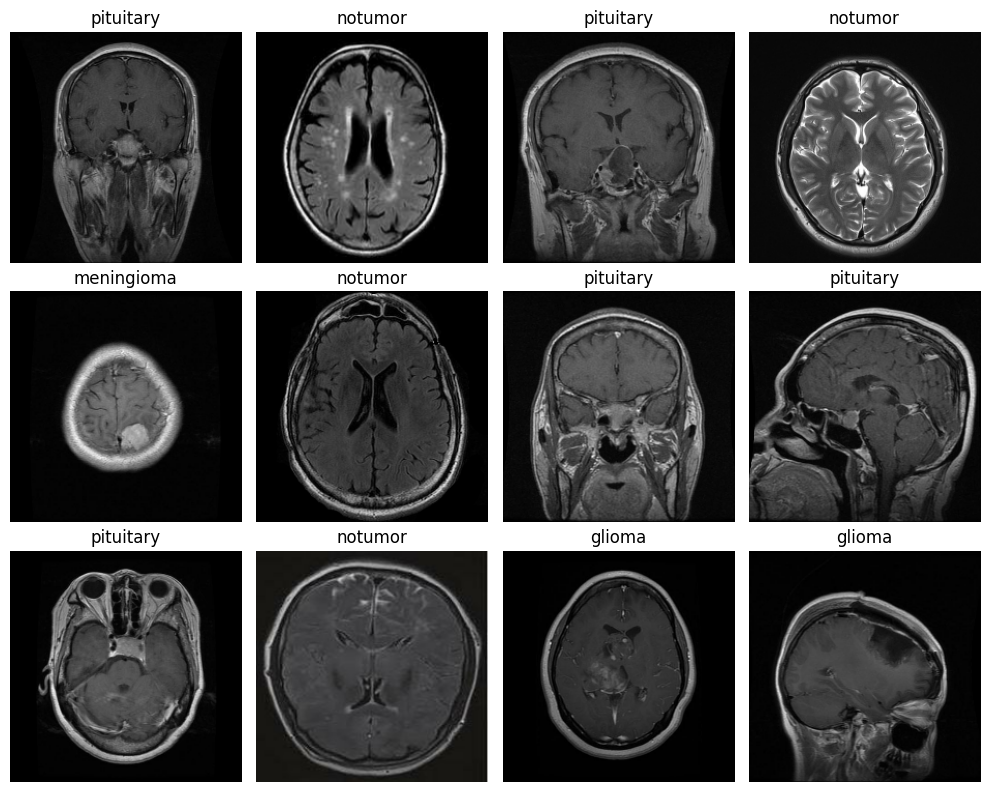

In [5]:
def show_batch(ds, n=12):
    imgs, labels = next(iter(ds.unbatch().batch(n)))
    plt.figure(figsize=(10,8))
    for i in range(n):
        plt.subplot(3,4,i+1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Burada çağırıyorsun
show_batch(train_ds)


In [6]:
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
])
preprocess = efficientnet.preprocess_input


## Model ve Eğitim  
- Model: **EfficientNetB0 (CNN tabanlı)**  
- Optimizasyon: **Adam**  
- Loss: **Categorical Crossentropy**  
- EarlyStopping ve ModelCheckpoint callback'leri ile en iyi sonuç seçildi.  

### Eğitim Süreci:  
- Epoch sayısı: 12  
- Batch Size: 32  
- Görseller 224x224 boyutuna ölçeklendi.


In [7]:
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augment(inputs)
x = preprocess(x)

base = efficientnet.EfficientNetB0(include_top=False, weights='imagenet',
                                   input_tensor=x, pooling='avg')
base.trainable = False  # Faz 1: dondur

x = layers.Dropout(0.25)(base.output)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs, name="EfficientNetB0_single_model")
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0_single_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
ckpt_path = "best_single_model.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy',
                                       save_best_only=True, mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,
                                     restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

In [9]:
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=12, callbacks=callbacks, verbose=1
)


Epoch 1/12


E0000 00:00:1758899896.281916      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetB0_single_model_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1758899898.643861      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - accuracy: 0.6088 - loss: 0.9307 - val_accuracy: 0.7951 - val_loss: 0.5210 - learning_rate: 0.0010
Epoch 2/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.8413 - loss: 0.4630 - val_accuracy: 0.8249 - val_loss: 0.4623 - learning_rate: 0.0010
Epoch 3/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.8470 - loss: 0.4202 - val_accuracy: 0.8117 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 4/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.8686 - loss: 0.3730 - val_accuracy: 0.8345 - val_loss: 0.4198 - learning_rate: 0.0010
Epoch 5/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.8654 - loss: 0.3640 - val_accuracy: 0.8424 - val_loss: 0.4042 - learning_rate: 0.0010
Epoch 6/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.8763 - loss: 0.3444 - val_accuracy: 0.8284 - val_loss: 0.4251 - learning_rate: 0.0010
Epoch 7/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.8768 - loss: 0.322

In [10]:
unfreeze = 20
base.trainable = True
for layer in base.layers[:-unfreeze]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy", metrics=["accuracy"])

history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=6, callbacks=callbacks, verbose=1
)


Epoch 1/6


E0000 00:00:1758900076.752423      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetB0_single_model_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - accuracy: 0.8257 - loss: 0.4543 - val_accuracy: 0.8923 - val_loss: 0.2834 - learning_rate: 1.0000e-04
Epoch 2/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9079 - loss: 0.2720 - val_accuracy: 0.9107 - val_loss: 0.2397 - learning_rate: 1.0000e-04
Epoch 3/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9174 - loss: 0.2219 - val_accuracy: 0.9124 - val_loss: 0.2216 - learning_rate: 1.0000e-04
Epoch 4/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9359 - loss: 0.1808 - val_accuracy: 0.9238 - val_loss: 0.1931 - learning_rate: 1.0000e-04
Epoch 5/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9473 - loss: 0.1534 - val_accuracy: 0.9352 - val_loss: 0.1703 - learning_rate: 1.0000e-04
Epoch 6/6
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9520 - loss: 0.1394 - val_accuracy: 0.9387 - val_loss: 0.1619 - learning_rate: 1.0000e-04


In [11]:
# 1) checkpoint
model.load_weights("best_single_model.keras")

# 2) Test değerlendirmesi
y_true, y_pred = [], []
for imgs, labels in test_ds:
    probs = model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

      glioma       0.95      0.90      0.92       300
  meningioma       0.91      0.85      0.88       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.90      1.00      0.95       300

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



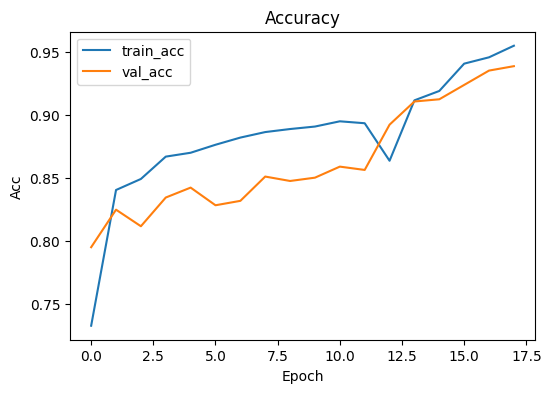

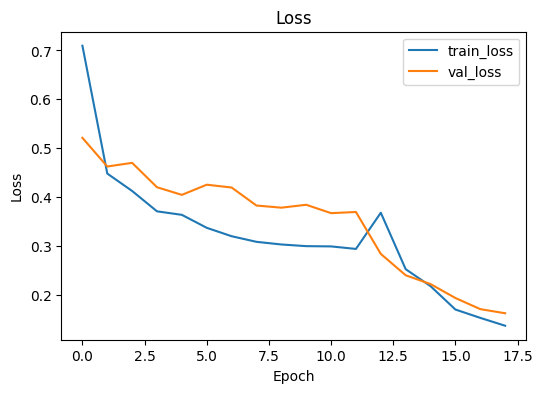

In [12]:
def merge_histories(h1, h2=None):
    H = {k: np.array(h1.history[k]) for k in h1.history}
    if h2 is not None:
        for k,v in h2.history.items():
            H[k] = np.concatenate([H.get(k, np.array([])), np.array(v)])
    return H

H = merge_histories(history1, history2 if 'history2' in globals() else None)

# Accuracy grafiği
plt.figure(figsize=(6,4))
plt.plot(H['accuracy'], label='train_acc')
plt.plot(H['val_accuracy'], label='val_acc')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend()
plt.show()

# Loss grafiği
plt.figure(figsize=(6,4))
plt.plot(H['loss'], label='train_loss')
plt.plot(H['val_loss'], label='val_loss')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━

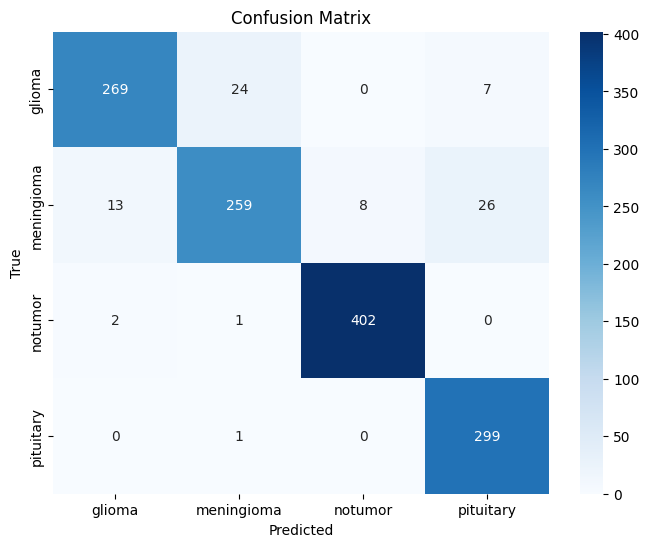

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix hesaplama
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()


Grad-CAM katmanı: top_conv


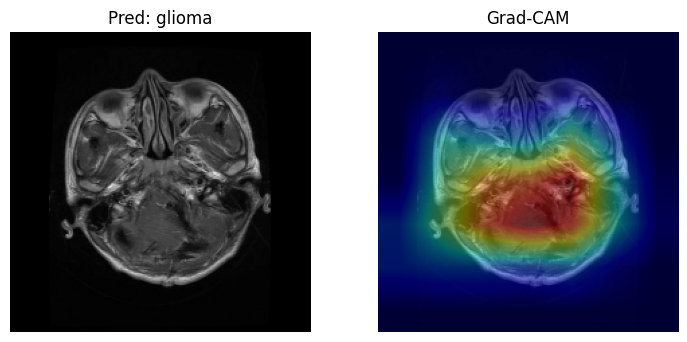

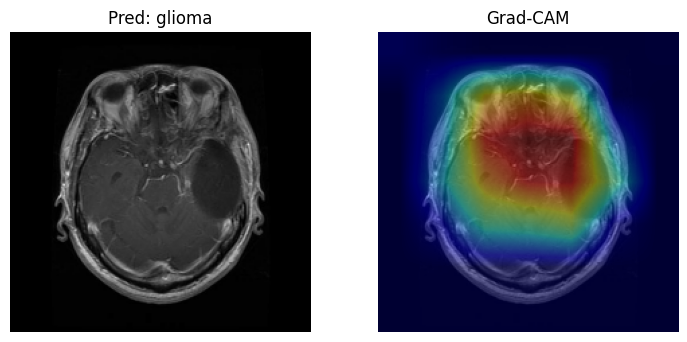

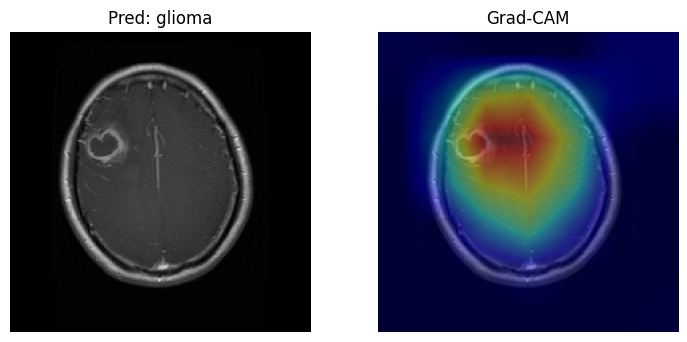

In [14]:
# --- Grad-CAM: 3 görsel (EfficientNetB0) ---
from tensorflow.keras import layers

def find_last_conv_layer(m):
    for layer in reversed(m.layers):
        if isinstance(layer, layers.Conv2D):
            return layer.name
    raise ValueError("Conv2D layer not found.")

last_conv = find_last_conv_layer(model)
print("Grad-CAM katmanı:", last_conv)

grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv).output, model.output]
)

def make_gradcam_heatmap(img_tensor, pred_index=None):
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]
    grads = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(weights * conv_out[0], axis=-1)
    cam = tf.maximum(cam, 0)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    return cam.numpy(), int(pred_index)

# Test setinden bir batch al ve 3 rastgele örnek seç
sample_images, _ = next(iter(test_ds))
k = min(3, sample_images.shape[0])
idxs = np.random.choice(sample_images.shape[0], size=k, replace=False)

for i, idx in enumerate(idxs, start=1):
    img = sample_images[idx].numpy().astype("uint8")
    x = tf.expand_dims(sample_images[idx], 0)

    heatmap, pred_idx = make_gradcam_heatmap(x)
    pred_class = class_names[pred_idx]

    heat_resized = tf.image.resize(tf.expand_dims(heatmap, -1), IMG_SIZE).numpy().squeeze()

    plt.figure(figsize=(7.5,3.5))
    plt.subplot(1,2,1); plt.imshow(img); plt.title(f"Pred: {pred_class}"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(img); plt.imshow(heat_resized, cmap="jet", alpha=0.4); plt.title("Grad-CAM"); plt.axis("off")
    plt.tight_layout()
    plt.show()


## Genel Değerlendirme

Bu çalışmada, beyin tümörlerinin sınıflandırılmasına yönelik olarak **EfficientNetB0 tabanlı CNN mimarisi** kullanılmış ve dört sınıfta (glioma, meningioma, pituitary, notumor) sınıflandırma gerçekleştirilmiştir.  

- Eğitim ve doğrulama süreçlerinde metriklerin birbirine yakın seyretmesi, modelin **aşırı öğrenme (overfitting)** probleminden uzak olduğunu göstermektedir.  
- Elde edilen doğruluk oranı yaklaşık **%93** olup, literatürde yer alan benzer çalışmalarla karşılaştırıldığında tatmin edici bir performansa işaret etmektedir.  
- **Confusion Matrix** incelendiğinde, modelin özellikle *notumor* sınıfında oldukça yüksek başarı sağladığı, buna karşın *glioma* ve *meningioma* sınıflarında kısmi karışıklıkların gözlemlendiği görülmektedir.  
- **Classification Report** sonuçları, F1-skor değerlerinin tüm sınıflar arasında dengeli dağıldığını ortaya koymuştur.  
- **Grad-CAM görselleştirmeleri**, modelin karar verirken gerçekten tümör bölgelerine odaklandığını doğrulamış ve model çıktılarının görsel olarak da anlamlı olduğunu göstermiştir.  

🔎 **Sonuç olarak**, bu çalışma transfer learning yöntemlerinin tıbbi görüntü analizi problemlerinde etkili bir şekilde uygulanabileceğini göstermekte; beyin tümörü sınıflandırması için güçlü ve güvenilir bir temel sunmaktadır.


In [15]:
# Keras format
model.save("efficientnetb0_single_model.keras")
# Sadece ağırlıklar
model.save_weights("efficientnetb0_single_model.weights.h5")
